1. Visualizing Hardware Topology


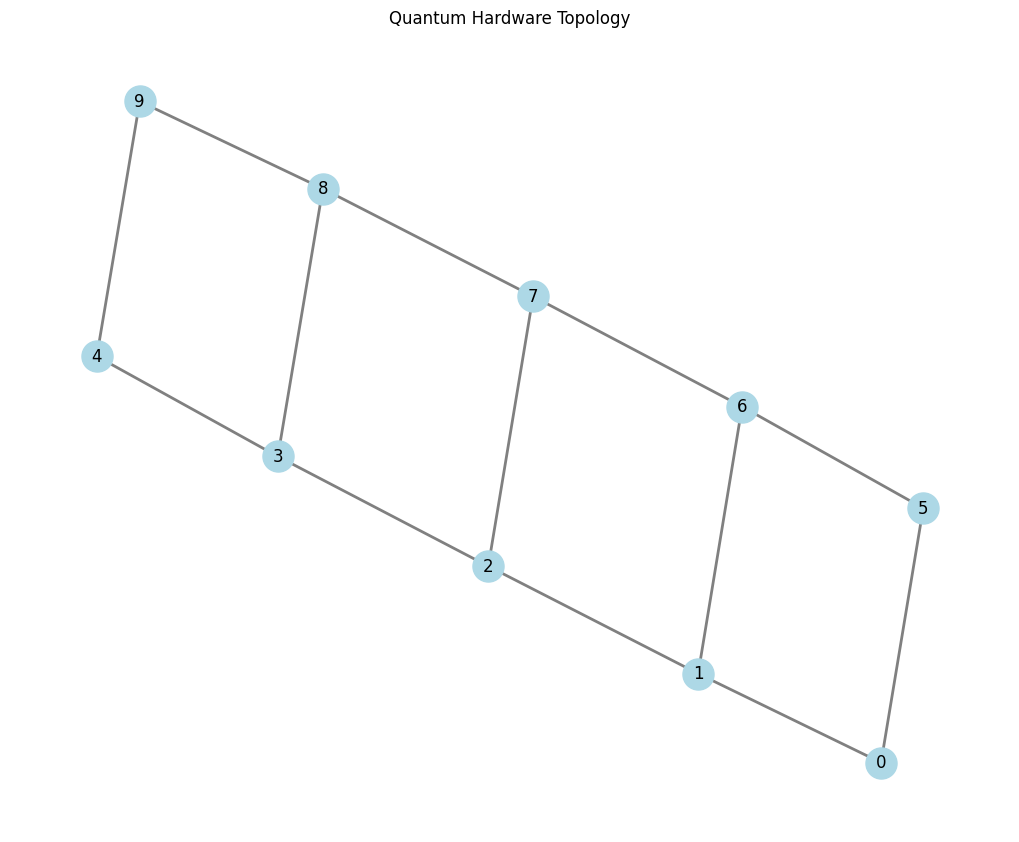


2. Finding and Visualizing Subgraphs
Found 32 connected 4-qubit subgraphs


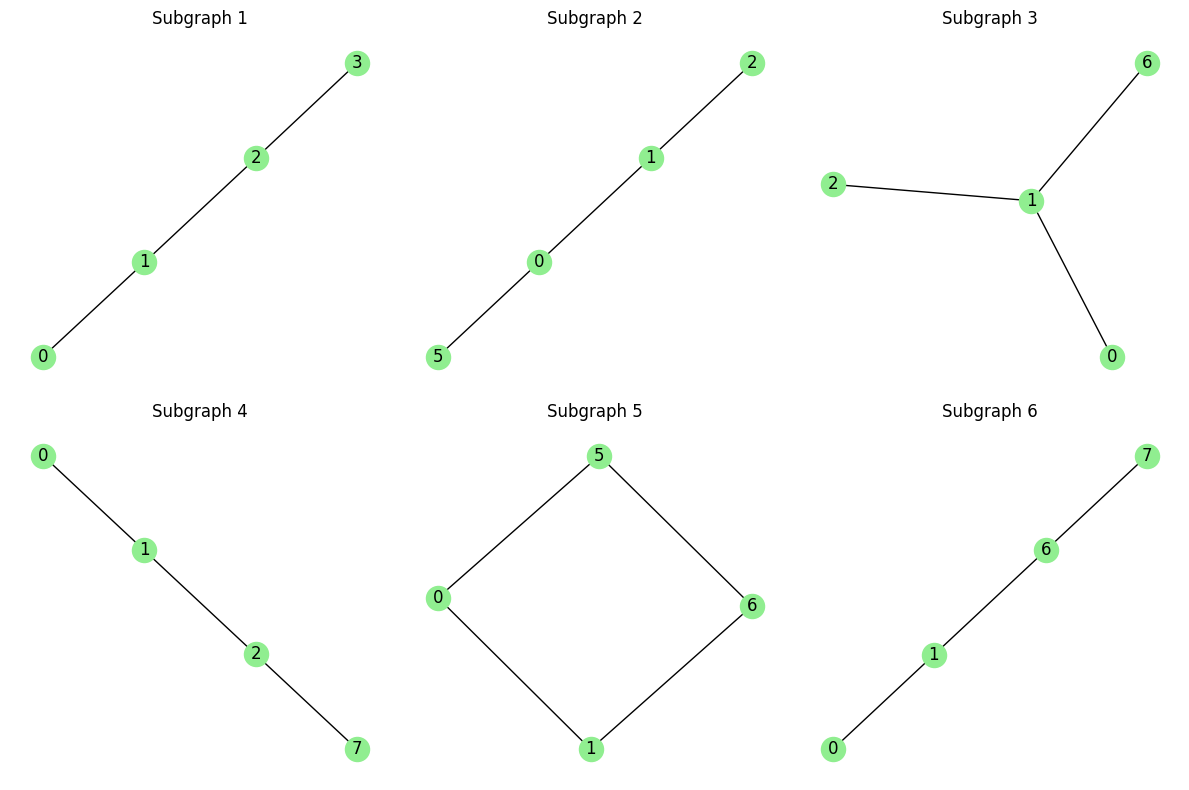


3. Testing Circuit Generation

Circuit depth 2 metrics:
expressivity: 0.39073393166776393
entanglement: 0.7565674951307819
depth: 7
n_parameters: 4
n_cnot: 4

Circuit depth 2:
             ┌───┐            ┌────────────────────┐                           »
q_0: ────────┤ X ├──────────X─┤ Rx(θ_test_d2_rx_2) ├────────────────────────■──»
     ┌───────┴───┴────────┐ │ └────────────────────┘┌────────────────────┐┌─┴─┐»
q_1: ┤ Rx(θ_test_d2_rx_0) ├─X───────────■───────────┤ Rz(θ_test_d2_rz_3) ├┤ X ├»
     ├────────────────────┤           ┌─┴─┐         └────────────────────┘├───┤»
q_2: ┤ Rx(θ_test_d2_rx_1) ├───────────┤ X ├───────────────────X───────────┤ S ├»
     └───────┬───┬────────┘           └───┘                   │           ├───┤»
q_3: ────────┤ H ├────────────────────────────────────────────X───────────┤ X ├»
             └───┘                                                        └───┘»
«               
«q_0: ──────────
«               
«q_1: ──■───────
«     ┌─┴─┐     
«q_2: ┤ X

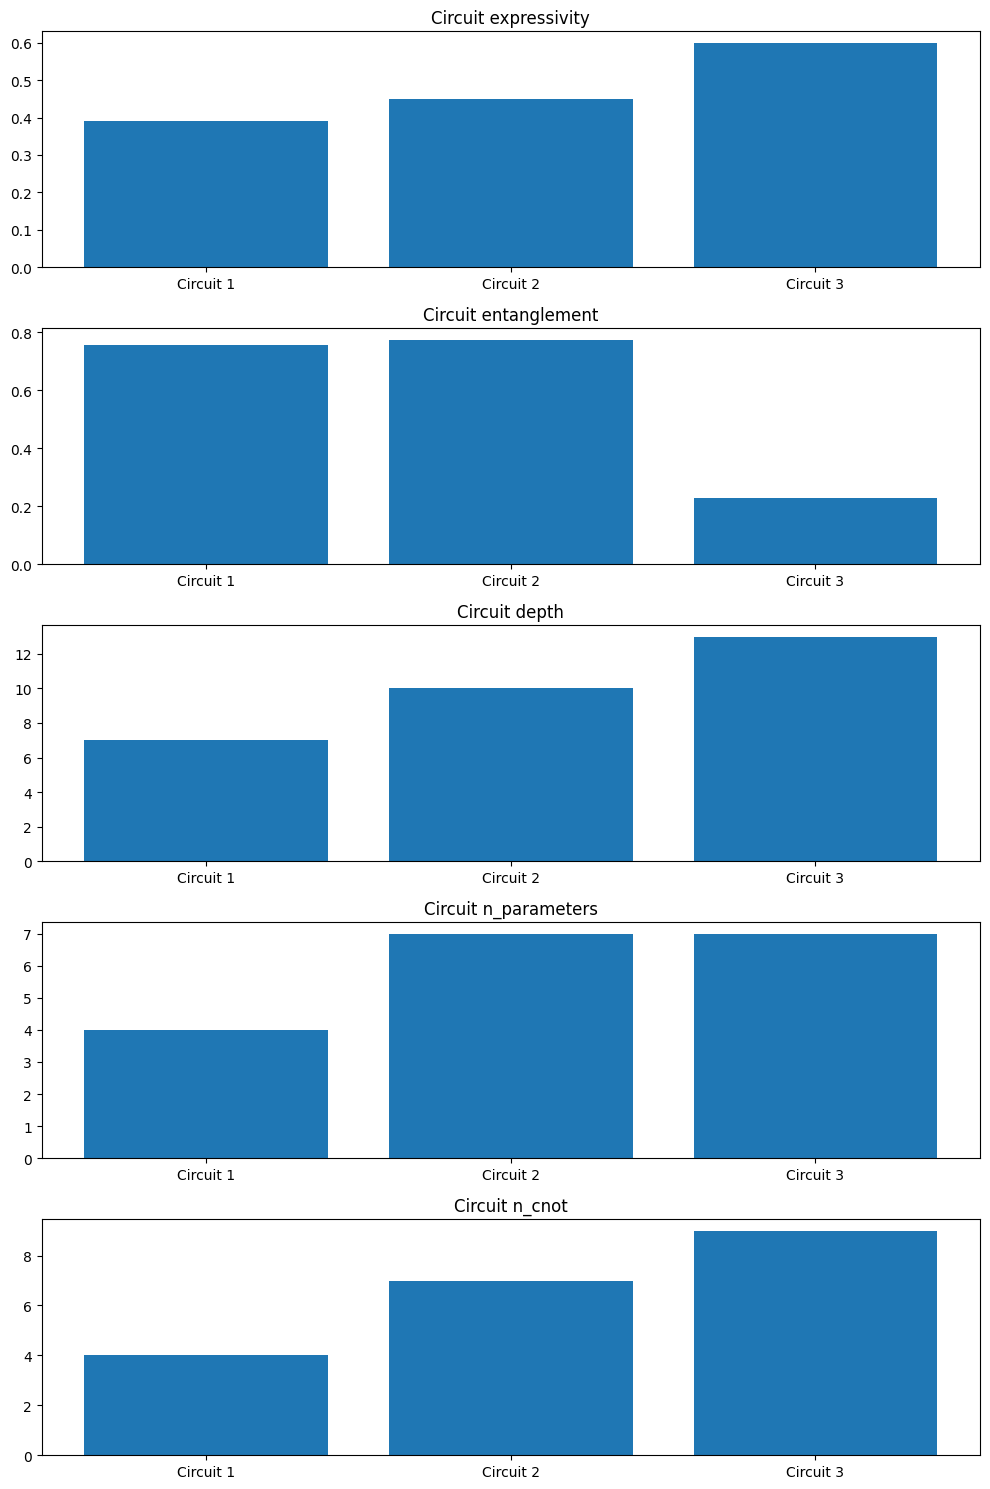


5. Testing Full Pipeline

Generated Ansatz:
     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
«     ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                    ├»
«     │                                                                                                                                     │»
«q_1: ┤1                                                                                                                                    ├»
«     │                                                                                                                                     │»
«q_2: ┤2                                                                                                                                    ├»
«     

In [1]:
# test_topolansatz.py
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
import numpy as np
from typing import List, Dict

from topolansatz.topology import TopologyHandler
from topolansatz.circuits import CircuitBuilder
from topolansatz.evaluator import CircuitEvaluator
from topolansatz.stitching import CircuitStitcher
from topolansatz.main import TopolAnsatz

def visualize_topology(coupling_map):
    """Visualize quantum hardware topology"""
    G = nx.Graph()
    G.add_edges_from(coupling_map)
    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=500, width=2, edge_color='gray')
    plt.title("Quantum Hardware Topology")
    plt.show()

def visualize_subgraphs(subgraphs: List[nx.Graph]):
    """Visualize found subgraphs"""
    n_graphs = len(subgraphs)
    cols = min(3, n_graphs)
    rows = (n_graphs + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[ax] for ax in axes]
        
    for i, subgraph in enumerate(subgraphs):
        row = i // cols
        col = i % cols
        pos = nx.spring_layout(subgraph)
        nx.draw(subgraph, pos, with_labels=True, 
                node_color='lightgreen',
                node_size=300,
                ax=axes[row][col])
        axes[row][col].set_title(f"Subgraph {i+1}")
    
    plt.tight_layout()
    plt.show()

def plot_circuit_metrics(metrics_list: List[Dict]):
    """Plot circuit quality metrics"""
    metrics = ['expressivity', 'entanglement', 'depth', 'n_parameters', 'n_cnot']
    n_circuits = len(metrics_list)
    
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 3*len(metrics)))
    
    for i, metric in enumerate(metrics):
        values = [m[metric] for m in metrics_list]
        axes[i].bar(range(n_circuits), values)
        axes[i].set_title(f"Circuit {metric}")
        axes[i].set_xticks(range(n_circuits))
        axes[i].set_xticklabels([f"Circuit {j+1}" for j in range(n_circuits)])
    
    plt.tight_layout()
    plt.show()

def main():
    # Test topology
    coupling_map = [
        (0,1), (1,2), (2,3), (3,4),
        (0,5), (1,6), (2,7), (3,8), (4,9),
        (5,6), (6,7), (7,8), (8,9)
    ]
    
    print("1. Visualizing Hardware Topology")
    visualize_topology(coupling_map)
    
    # Initialize components
    topology = TopologyHandler(coupling_map)
    evaluator = CircuitEvaluator()
    
    print("\n2. Finding and Visualizing Subgraphs")
    subgraphs = topology.get_connected_subgraphs(4)  # Get 4-qubit subgraphs
    print(f"Found {len(subgraphs)} connected 4-qubit subgraphs")
    visualize_subgraphs(subgraphs[:6])  # Show first 6 subgraphs
    
    print("\n3. Testing Circuit Generation")
    # Generate test circuits with different depths
    test_circuits = []
    test_metrics = []
    
    for depth in [2, 3, 4]:
        # Take first subgraph and normalize it
        norm_graph, index_map = topology.normalize_indices(subgraphs[0])
        
        # Create circuit
        builder = CircuitBuilder(norm_graph, f"test_d{depth}")
        circuit = builder.create_circuit(depth=depth)
        test_circuits.append(circuit)
        
        # Get metrics
        metrics = evaluator.get_circuit_metrics(circuit)
        test_metrics.append(metrics)
        
        print(f"\nCircuit depth {depth} metrics:")
        for key, value in metrics.items():
            print(f"{key}: {value}")
            
        # Draw circuit
        print(f"\nCircuit depth {depth}:")
        print(circuit.draw())
    
    print("\n4. Plotting Circuit Metrics")
    plot_circuit_metrics(test_metrics)
    
    print("\n5. Testing Full Pipeline")
    # Create TopolAnsatz instance
    topol = TopolAnsatz(coupling_map)
    
    # Generate 8-qubit ansatz
    ansatz = topol.generate_ansatz(n_qubits=8, depth=3)
    print("\nGenerated Ansatz:")
    print(ansatz.draw())
    
    # Evaluate final ansatz
    final_metrics = topol.evaluate_ansatz(ansatz)
    print("\nFinal Ansatz Metrics:")
    for key, value in final_metrics.items():
        print(f"{key}: {value}")

if __name__ == "__main__":
    main()